<a href="https://colab.research.google.com/github/LeeGitaek/Kaggle_Netflix_Stock_Prediction/blob/master/kaggle_netflix_defense.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [217]:
!pip uninstall kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.6

Found existing installation: kaggle 1.5.6
Uninstalling kaggle-1.5.6:
  Would remove:
    /usr/local/bin/kaggle
    /usr/local/lib/python3.6/dist-packages/kaggle-1.5.6.dist-info/*
    /usr/local/lib/python3.6/dist-packages/kaggle/*
Proceed (y/n)? y
  Successfully uninstalled kaggle-1.5.6
Requirement already up-to-date: pip in /usr/local/lib/python3.6/dist-packages (20.1.1)
Processing /root/.cache/pip/wheels/01/3e/ff/77407ebac3ef71a79b9166a8382aecf88415a0bcbe3c095a01/kaggle-1.5.6-py3-none-any.whl
Found existing installation: kaggle 1.5.6
Uninstalling kaggle-1.5.6:
  Would remove:
    /usr/local/bin/kaggle
    /usr/local/lib/python3.6/dist-packages/kaggle-1.5.6.dist-info/*
    /usr/local/lib/python3.6/dist-packages/kaggle/*
Proceed (y/n)? 

In [218]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle
!ls -lha kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

-rw-r--r-- 1 root root 68 Jun 17 13:05 kaggle.json


In [219]:
!kaggle competitions download -c netflix-stock-prediction

netflix-stock-prediction.zip: Skipping, found more recently modified local copy (use --force to force download)


In [220]:
!unzip netflix-stock-prediction.zip

Archive:  netflix-stock-prediction.zip
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: sample_submission.csv   
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 
error:  invalid response [{ENTER}]
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: test.csv                
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train.csv               


In [221]:
import numpy as np 
import random
import pandas as pd 
import matplotlib.pyplot as plt
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
import torch
import torch.nn as nn
from torch.autograd import Variable

torch.manual_seed(1)

In [222]:
df_train = pd.read_csv('train.csv',parse_dates=True)
df_test = pd.read_csv('test.csv',parse_dates=True)
sc = MinMaxScaler()
df_train.head()

,Date,Open,High,Low,Volume,Close
0,2015-12-16,120,123,118,13181000,123
1,2015-12-17,124,126,122,17284900,123
2,2015-12-18,121,122,118,17948100,118
3,2015-12-21,120,120,116,11670000,117
4,2015-12-22,117,117,115,9689000,116


In [223]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 967 entries, 0 to 966
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    967 non-null    object
 1   Open    967 non-null    int64 
 2   High    967 non-null    int64 
 3   Low     967 non-null    int64 
 4   Volume  967 non-null    int64 
 5   Close   967 non-null    int64 
dtypes: int64(5), object(1)
memory usage: 45.5+ KB


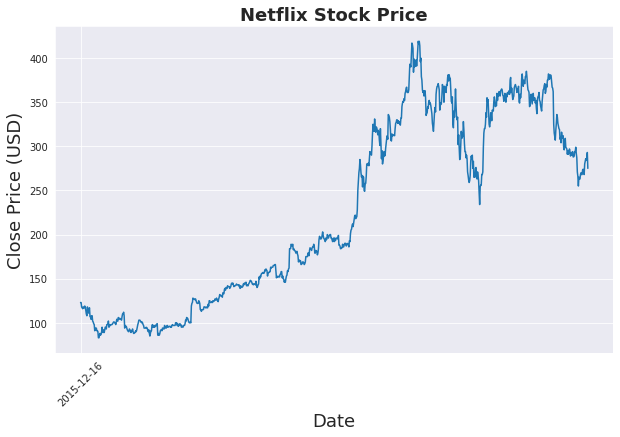

In [224]:
import seaborn as sns

sns.set_style("darkgrid")
plt.figure(figsize = (10,6))
plt.plot(df_train[['Close']])
plt.xticks(range(0,df_train.shape[0],967),df_train['Date'].loc[::967],rotation=45)
plt.title('Netflix Stock Price',fontsize=18, fontweight='bold')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price (USD)',fontsize=18)
plt.show()

In [225]:
price = df_train[['Close']]
price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 967 entries, 0 to 966
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Close   967 non-null    int64
dtypes: int64(1)
memory usage: 7.7 KB


In [226]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [227]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

In [228]:
lookback = 20 # choose sequence length
x_train, y_train, x_test, y_test = split_data(price, lookback)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (758, 19, 1)
y_train.shape =  (758, 1)
x_test.shape =  (189, 19, 1)
y_test.shape =  (189, 1)


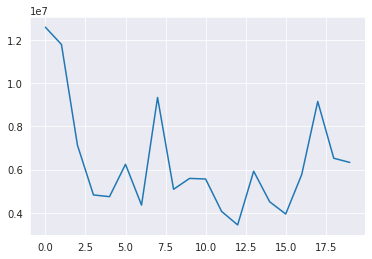

In [229]:
df_test['Volume'].plot()

In [230]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

In [231]:
input_dim = 1
hidden_dim = 36
num_layers = 2
output_dim = 1
num_epochs = 100

In [232]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True,dropout=0.3)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [233]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.001)

In [234]:
import time

hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []

for t in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train_lstm)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.5211817622184753
Epoch  1 MSE:  0.5074238181114197
Epoch  2 MSE:  0.49422839283943176
Epoch  3 MSE:  0.48092567920684814
Epoch  4 MSE:  0.46832984685897827
Epoch  5 MSE:  0.4557032585144043
Epoch  6 MSE:  0.4421101212501526
Epoch  7 MSE:  0.4281618595123291
Epoch  8 MSE:  0.4141049087047577
Epoch  9 MSE:  0.39990246295928955
Epoch  10 MSE:  0.3854033648967743
Epoch  11 MSE:  0.3694615364074707
Epoch  12 MSE:  0.3543016016483307
Epoch  13 MSE:  0.33701446652412415
Epoch  14 MSE:  0.3196917474269867
Epoch  15 MSE:  0.30268988013267517
Epoch  16 MSE:  0.28561776876449585
Epoch  17 MSE:  0.2683698236942291
Epoch  18 MSE:  0.25463664531707764
Epoch  19 MSE:  0.24515442550182343
Epoch  20 MSE:  0.23704500496387482
Epoch  21 MSE:  0.23421689867973328
Epoch  22 MSE:  0.23477338254451752
Epoch  23 MSE:  0.2328183650970459
Epoch  24 MSE:  0.22480762004852295
Epoch  25 MSE:  0.21323853731155396
Epoch  26 MSE:  0.19888432323932648
Epoch  27 MSE:  0.18352846801280975
Epoch  28 MSE:

In [235]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_lstm.detach().numpy()))

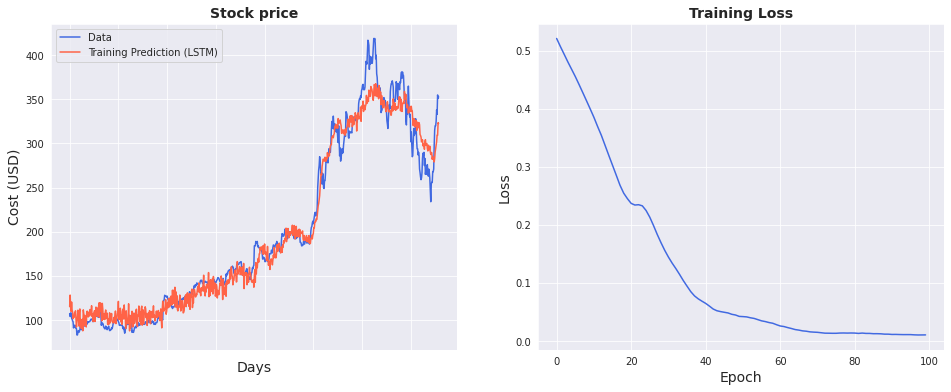

In [236]:
import seaborn as sns
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (LSTM)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

In [237]:
import math, time
from sklearn.metrics import mean_squared_error
model.eval()
# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train_lstm.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_lstm.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
lstm.append(trainScore)
lstm.append(testScore)
lstm.append(training_time)

Train Score: 17.20 RMSE
Test Score: 19.18 RMSE


In [238]:
trainPredictPlot = np.empty_like(price)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lookback:len(y_train_pred)+lookback, :] = y_train_pred

# shift test predictions for plotting
testPredictPlot = np.empty_like(price)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+lookback-1:len(price)-1, :] = y_test_pred

original = scaler.inverse_transform(price['Close'].values.reshape(-1,1))

predictions = np.append(trainPredictPlot, testPredictPlot, axis=1)
predictions = np.append(predictions, original, axis=1)
result = pd.DataFrame(predictions)

In [239]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[0],
                    mode='lines',
                    name='Train prediction')))
fig.add_trace(go.Scatter(x=result.index, y=result[1],
                    mode='lines',
                    name='Test prediction'))
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[2],
                    mode='lines',
                    name='Actual Value')))
fig.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=True,
        showticklabels=False,
        linecolor='white',
        linewidth=2
    ),
    yaxis=dict(
        title_text='Close (USD)',
        titlefont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='white',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
    ),
    showlegend=True,
    template = 'plotly_dark'

)



annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Results (LSTM)',
                              font=dict(family='Rockwell',
                                        size=26,
                                        color='white'),
                              showarrow=False))
fig.update_layout(annotations=annotations)

fig.show()

In [240]:
print(len(result[1].dropna(axis=0)))

189


In [241]:
result[1] = result[1].dropna(axis=0)
predict = result[1].tail(21).dropna(axis=0)
print(len(predict))
print(predict.astype('int'))

20
946    308
947    307
948    306
949    303
950    301
951    299
952    297
953    295
954    294
955    293
956    292
957    291
958    291
959    291
960    291
961    291
962    291
963    292
964    293
965    294
Name: 1, dtype: int64


In [242]:
predict = np.array(predict).reshape(-1,1).astype('int')
id = np.array([i+1 for i in range(len(predict))]).reshape(-1,1)
result = np.hstack([id,predict])
df = pd.DataFrame(result,columns=["Id","Expected"])
df.to_csv("baseline.csv",index=False,header=True)

In [243]:
!kaggle competitions submit -c netflix-stock-prediction -f baseline.csv -m "baseline"

100% 143/143 [00:02<00:00, 52.0B/s]
Successfully submitted to 넷플릭스 주가 예측